# Disaster Tweets data analysis

In [1]:
import numpy as np
import re
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, ensemble, model_selection, pipeline, compose, preprocessing
from keyword_transformer import KeywordTransformer
from location_transformer import LocationTransformer
from text_stats_transformer import TextStatsTransformer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# import spacy
# spacy.cli.download('en_core_web_sm')


In [2]:
df_train = pd.read_csv('./train_enriched.csv', index_col='id')
df_test = pd.read_csv('./test_enriched.csv', index_col='id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 0 to 7612
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   keyword              7552 non-null   object 
 1   positive_factor      7613 non-null   float64
 2   location             5080 non-null   object 
 3   country              2648 non-null   object 
 4   state                1640 non-null   object 
 5   city                 1518 non-null   object 
 6   missing_location     7613 non-null   int64  
 7   text                 7613 non-null   object 
 8   clean_text           7613 non-null   object 
 9   text_length          7613 non-null   int64  
 10  upper_text_factor    7613 non-null   float64
 11  tags_count           7613 non-null   int64  
 12  punct_factor         7613 non-null   float64
 13  ann_count            7613 non-null   int64  
 14  urls_count           7613 non-null   int64  
 15  tokens_count         7613 non-null   int64 

In [3]:
df_train.sample(n=10)

,keyword,positive_factor,location,country,state,city,missing_location,text,clean_text,text_length,...,tags_count,punct_factor,ann_count,urls_count,tokens_count,stop_words_factor,clean_tokens_factor,url_domains,url_redirects_count,target
id,,,,,,,,,,,,,,,,,,,,,
7224,weapons,0.435897,Beirut/Toronto,Lebanon,NaN,Beirut,0,Friendly reminder that the only country to eve...,friendly reminder country ever use nuclear wea...,114,...,0,0.070175,0,1,20,0.450000,0.500000,NaN,0,1
6123,sinking,0.195122,MA,MA,NaN,NaN,0,that horrible sinking feeling when youÛªve be...,horrible sinking feeling youûªve home phone r...,105,...,0,0.000000,0,0,25,0.600000,0.400000,NaN,0,1
579,bioterror,0.594595,"Silver Spring, MD",United States,Maryland,Silver Spring,0,.@APHL responds: FedEx no longer to transport ...,aphl responds fedex longer transport bioterror...,100,...,0,0.080000,1,1,16,0.250000,0.687500,usat.ly,1,1
7488,wreck,0.189189,new york,NaN,NaN,NaN,0,act my age was a MESS everyone was so wild it ...,act age mess everyone wild fun video wreck,57,...,0,0.000000,0,0,18,0.555556,0.444444,NaN,0,0
6816,trapped,0.281250,Orlando,United States,Florida,Orlando,0,Hollywood Movie About Trapped Miners Released ...,hollywood movie trapped miner released chile t...,120,...,0,0.091667,0,1,17,0.117647,0.823529,abcn.ws,1,0
1971,cyclone,0.593750,NaN,NaN,NaN,NaN,1,1970 Mercury Cyclone GT Hood Moulding Very NIC...,mercury cyclone gt hood moulding nice core cob...,103,...,0,0.097087,0,2,15,0.000000,0.866667,newoffers.info twitter.com,2,0
321,armageddon,0.119048,Here And There,NaN,NaN,NaN,0,Armageddon https://t.co/uCSUDk3q1d,armageddon,33,...,0,0.151515,0,1,2,0.000000,0.500000,NaN,0,1
2545,destroy,0.243243,"San Diego, CA",United States,California,San Diego,0,Plot\nIn the futurea totalitarian government e...,plot futurea totalitarian government employ fo...,121,...,0,0.041322,0,1,20,0.350000,0.600000,NaN,0,0
33,ablaze,0.361111,AFRICA,NaN,NaN,NaN,0,#AFRICANBAZE: Breaking news:Nigeria flag set a...,africanbaze breaking newsnigeria flag set abla...,74,...,1,0.121622,0,1,9,0.111111,0.777778,africanbaze.com,2,1


In [4]:
df_train.fillna(value={'keyword': '', 'location': ''}, inplace=True)
df_train.sample(n=10)

,keyword,positive_factor,location,country,state,city,missing_location,text,clean_text,text_length,...,tags_count,punct_factor,ann_count,urls_count,tokens_count,stop_words_factor,clean_tokens_factor,url_domains,url_redirects_count,target
id,,,,,,,,,,,,,,,,,,,,,
4050,forest%20fires,0.843750,,NaN,NaN,NaN,1,Reddit: http://t.co/UtuMVaABz6 Lightning spark...,reddit lightning spark new fire boise national...,87,...,0,0.091954,0,1,11,0.090909,0.818182,ktvb.com,2,1
5289,outbreak,0.975000,??????,NaN,NaN,NaN,0,'Legionnaires' Disease: What's Being Done to S...,legionnaire disease whats done stop deadly out...,91,...,1,0.230769,0,1,11,0.090909,0.818182,go.com,2,1
4426,hostage,0.483871,,NaN,NaN,NaN,1,quoted here--&gt;CNN: Purported ISIS video thr...,quoted heregtcnn purported isi video threatens...,84,...,0,0.119048,0,1,9,0.000000,0.888889,cnn.it,1,1
4751,lightning,0.515152,USA,United States,NaN,NaN,0,Phones Offers &gt;&gt; http://t.co/bYtbZ8s5ux ...,phone offer gtgt 8pin lightning connector 21a ...,126,...,1,0.150794,0,2,20,0.000000,0.900000,ebay.com twitter.com,3,0
6257,snowstorm,0.448276,Italy,Italy,NaN,NaN,0,Snowstorm planned outside #Rome's St Mary Majo...,snowstorm planned outside rome st mary major t...,116,...,1,0.034483,0,0,22,0.136364,0.863636,NaN,0,0
4119,hailstorm,0.750000,Massachusetts,NaN,Massachusetts,NaN,0,Twin Storms Blow Through Calgary ~ 1 http://t....,twin storm blow calgary,74,...,0,0.148649,0,2,9,0.000000,0.777778,usnewsapp.com twitter.com,3,1
2251,deluged,0.259259,,NaN,NaN,NaN,1,Businesses are deluged with invokces. Make you...,business deluged invokces make stand colour sh...,109,...,0,0.045872,0,0,24,0.500000,0.500000,NaN,0,0
5448,police,0.567568,UK,NaN,NaN,NaN,0,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,dt georgegalloway rt galloway4mayor ûïthe col...,111,...,0,0.108108,2,1,15,0.200000,0.733333,pltw.ps,1,1
576,bioterror,0.594595,"West Virginia, USA",United States,West Virginia,NaN,0,FedEx no longer to transport bioterror germs i...,fedex longer transport bioterror germ wake ant...,97,...,0,0.061856,1,1,16,0.250000,0.687500,usat.ly,1,1


## Text vectors

In [5]:
vc_text = feature_extraction.text.TfidfVectorizer(max_features=2000)
vc_text.fit(df_train['clean_text'])


TfidfVectorizer(max_features=2000)

In [6]:
vectors = vc_text.transform(df_train['clean_text'])


In [7]:
for t in vc_text.get_feature_names_out():
    print(t)

11yearold
16yr
1st
2nd
300w
3g
4x4
53inch
5km
70th
aba
abandoned
abc
ablaze
able
absolutely
abstorm
access
accident
according
account
acre
across
act
action
activity
actually
add
added
adult
advisory
af
affected
afghanistan
africa
afternoon
aftershock
again
age
ago
agree
ah
ahead
aid
aim
aint
air
aircraft
airline
airplane
airport
aka
al
alabama
alarm
alaska
album
alert
alive
all
allah
allows
almost
alone
along
already
also
always
amazing
amazon
ambulance
america
american
amid
among
amp
amsterdam
an
anchorage
ancient
and
angel
angry
animal
animalrescue
annihilated
annihilation
anniversary
annual
another
answer
anthrax
anti
antioch
anymore
anyone
anything
ap
apartment
apc
apocalypse
apollo
app
apparently
appears
apply
approach
ar
arabia
area
arianagrande
arm
armageddon
army
around
arrested
arrived
arson
arsonist
art
article
as
ash
ask
asked
asking
associated
at
atomic
attack
attacked
attention
auction
audio
aug
august
aussie
australia
australian
automatic
avalanche
ave
averted
avoid
avoi

In [8]:
docs_tokenized = [re.split('\\s+', txt) for index, txt in df_train['clean_text'].items()]
docs_tokenized[0]


['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']

In [9]:
tagged_data = [TaggedDocument(words=tokens, tags=[index]) for index, tokens in enumerate(docs_tokenized)]
tagged_data[0]

TaggedDocument(words=['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u'], tags=[0])

In [10]:
model = Doc2Vec(vector_size=200, min_count=1, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [11]:
vectors = [model.infer_vector(tokens) for tokens in docs_tokenized]


In [12]:
vectors[1]

array([-2.36970242e-02,  2.01229993e-02,  4.11202200e-02,  7.65569508e-02,
        6.45987019e-02, -1.16848119e-03, -1.21054798e-02,  2.98936162e-02,
       -5.50621003e-02, -1.85479987e-02, -5.18708080e-02, -2.46465132e-02,
       -2.73672566e-02,  9.51592904e-03,  5.55775221e-03, -2.03352813e-02,
       -4.33735400e-02,  1.11950403e-02,  1.95551161e-02, -4.71375138e-02,
        4.91754292e-03, -6.76283659e-03,  1.69324763e-02,  7.08104623e-03,
        5.44270016e-02, -3.02496422e-02, -4.68266495e-02,  1.96267478e-02,
       -5.45306802e-02,  3.93475443e-02,  1.61986649e-02,  3.31680290e-02,
        3.00219823e-02,  1.74357798e-02,  4.06514667e-03,  1.45397140e-02,
        1.33348312e-02,  6.60783723e-02,  7.51235930e-05, -5.91604710e-02,
        3.91315036e-02,  2.19718385e-02,  4.05116342e-02,  2.75734346e-02,
        1.05250090e-01, -3.01213060e-02, -1.92676745e-02, -4.51900624e-02,
       -1.43829826e-03,  4.63418923e-02, -1.22142294e-02, -2.36225105e-03,
       -4.74635400e-02, -

## Features selection

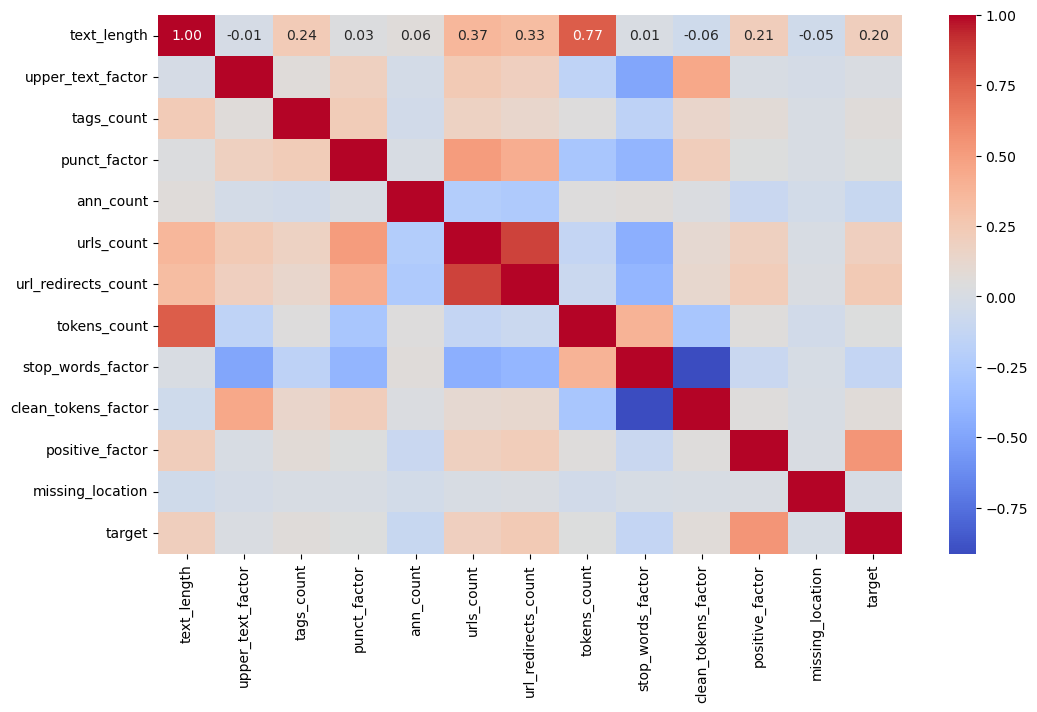

In [20]:
selected_features = ['text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 
                     'urls_count', 'url_redirects_count',
                     'tokens_count', 'stop_words_factor', 'clean_tokens_factor', 'positive_factor',
                     'missing_location',
                     'target']
df_corr = df_train[selected_features].copy().corr()

plt.figure(figsize=(12, 7))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=df_corr.columns, yticklabels=df_corr.columns)
plt.show()